In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import scipy as scipy
import scipy.stats as sc
import numpy as np
import pandas as pd
import os
import re
from calendar import isleap

In [3]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

In [4]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series_full.nc')

In [20]:
aht_ds

<xarray.Dataset>
Dimensions:                     (time: 63184, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-01 ... 2022-03-...
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

In [5]:
temp_data = xr.open_mfdataset('../era5_data/zonal_mean/*')

In [15]:
temp_data = temp_data.compute()

temp_data

<xarray.Dataset>
Dimensions:      (time: 2312, level: 37, latitude: 361)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 ... 1980-07-31T18:00:00
  * level        (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * latitude     (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
Data variables:
    T_zonal_ave  (time, level, latitude) float64 267.1 267.2 267.6 ... 0.0 0.0
    q_zonal_ave  (time, level, latitude) float64 3.833e-06 3.83e-06 ... 0.0 0.0
    z_zonal_ave  (time, level, latitude) float64 4.257e+05 4.258e+05 ... 0.0 0.0

In [34]:
aht_ds_subset = aht_ds.sel(time=temp_data.time)

aht_ds_subset_djf = aht_ds_subset.sel(time=aht_ds_subset.time.dt.month.isin([12, 1, 2]))
temp_data_djf = temp_data.sel(time=temp_data.time.dt.month.isin([12, 1, 2]))

In [13]:
def normalize(da):
    
    return (da.groupby('time.dayofyear') - da.groupby('time.dayofyear').mean('time')) / da.groupby('time.dayofyear').std('time')

In [54]:
temp_anom_djf = temp_data_djf.groupby('time.dayofyear') - temp_data_djf.groupby('time.dayofyear').mean('time')

aht_anom_djf = aht_ds_subset_djf.total_aht_no_seasons.groupby('time.dayofyear') - aht_ds_subset_djf.total_aht_no_seasons.groupby('time.dayofyear').mean('time')


In [121]:
which_lat = 40

aht_ds_lat = -aht_anom_djf.differentiate('latitude').sel(latitude=which_lat)

aht_times = aht_ds_lat.sortby(aht_ds_lat, ascending=False)[:int(0.3 * len(aht_ds_lat.time))]

aht_times_idxs = np.searchsorted(aht_anom_djf.time, aht_times.time.values)

In [122]:
new_times = []

for time in aht_times_idxs:
    add_flag = True
    for i in np.arange(-5, 6, 1):
        if time + i in new_times:
            add_flag = False
    if add_flag == True:
        new_times.append(time)
        
#new_times

aht_times_idxs = np.array(new_times)

In [123]:
aht_times_idxs = aht_times_idxs[(582 > aht_times_idxs) & (aht_times_idxs > 18)]

In [124]:
num_lags = 17

temp_array = np.zeros((37, 2 * num_lags - 1))
sphum_array = np.zeros((37, 2 * num_lags - 1))

for idx, lag in enumerate(np.arange(-16, 17, 1)):
    try:
        temp_one = temp_anom_djf.T_zonal_ave.isel(time=aht_times_idxs + lag).sel(latitude=which_lat)
        sphum_one = temp_anom_djf.q_zonal_ave.isel(time=aht_times_idxs + lag).sel(latitude=which_lat)
    except IndexError:
        print('Error')
    
    temp_array[:, idx] = temp_one.mean('time').values
    sphum_array[:, idx] = sphum_one.mean('time').values

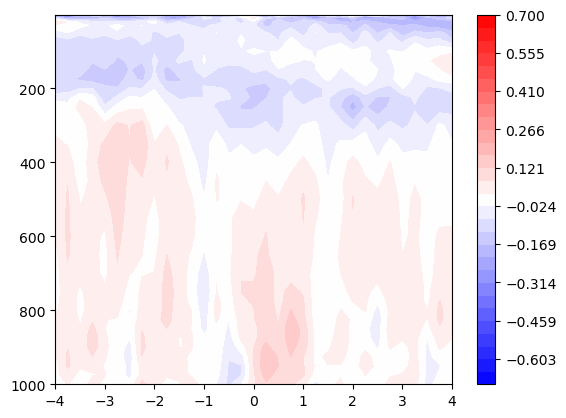

In [125]:
plt.contourf(np.linspace(-4, 4, 33), temp_data.level.values, temp_array, cmap='bwr',
             levels=np.linspace(-0.7, 0.7, 30))

plt.gca().invert_yaxis()

plt.colorbar()
plt.show()

In [58]:
temp_anom_djf.T_zonal_ave

<xarray.DataArray 'T_zonal_ave' (time: 600, level: 37, latitude: 361)>
array([[[ 2.22893887e+01,  2.24323433e+01,  2.27968138e+01, ...,
          1.67708274e+00,  1.78405880e+00,  1.81343842e+00],
        [ 9.92188644e+00,  9.97579693e+00,  1.00502062e+01, ...,
         -9.71742588e-01, -1.29726630e+00, -1.41466141e+00],
        [-9.18237686e-01, -1.08327912e+00, -1.27867249e+00, ...,
         -1.04510167e+00, -8.09999000e-01, -7.07309723e-01],
        ...,
        [-6.69366264e+00, -6.78430002e+00, -6.90176947e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.85992432e+00, -4.07125125e+00, -4.67918362e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.55302811e+00, -2.77756339e+00, -3.26807124e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 2.44399624e+01,  2.43596871e+01,  2.40943289e+01, ...,
          2.65763287e+00,  2.81718055e+00,  2.88100433e+00],
        [ 6.94332504e+00,  7.08329375e+00,  7.40082906e+00, ...,
         -1.96893700e+00, -1.93834093e+00, -1.92250443e+00],
        [-3.49253273e+00, -3.39297320e+00, -3.13841269e+00, ...,
          8.82935164e-01,  9.07401445e-01,  8.88332367e-01],
...
        [-5.48645020e-01, -4.89120144e-01, -3.87629869e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-7.63763428e-01, -8.00604248e-01, -6.67991130e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.06970215e+00, -9.03818427e-01, -5.12268066e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.22909546e-02, -4.16047838e-02, -1.31384108e-01, ...,
          3.39167277e-01,  4.05114916e-01,  4.14222717e-01],
        [-2.52265930e-01, -9.68446520e-02,  3.01193068e-01, ...,
         -1.68468035e+00, -1.71317359e+00, -1.73517609e+00],
        [ 2.11766052e+00,  1.92092556e+00,  1.43803948e+00, ...,
         -8.99851057e-01, -1.01599486e+00, -1.02541733e+00],
        ...,
        [-3.11901855e+00, -2.85875448e+00, -2.20695767e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-3.63514709e+00, -3.37604743e+00, -2.90043844e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-6.65023804e-01, -8.04703776e-01, -1.11096429e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 ... 1980-02-29T18:00:00
  * level      (level) float64 1.0 2.0 3.0 5.0 7.0 ... 925.0 950.0 975.0 1e+03
  * latitude   (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
    dayofyear  (time) int64 1 1 1 1 2 2 2 2 3 3 ... 58 59 59 59 59 60 60 60 60

In [32]:
temp_aht_corr = xr.corr(-aht_norm.differentiate('latitude').sel(latitude=40), temp_anom, dim='time')

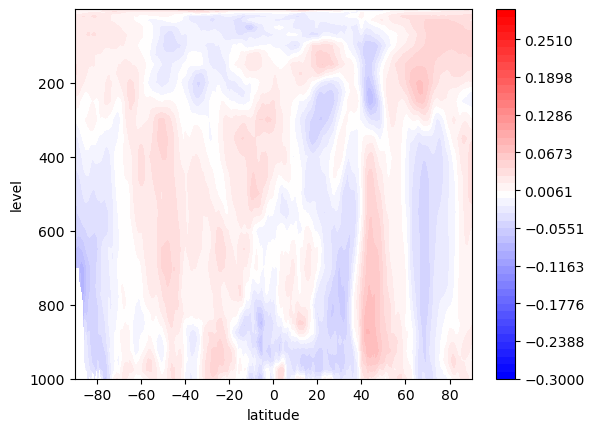

In [33]:
temp_aht_corr.plot.contourf(cmap='bwr', levels=np.linspace(-0.3, 0.3))


plt.gca().invert_yaxis()

plt.show()